
<div class="alert alert-info">

**This is a fixed-text formatted version of a Jupyter notebook**

- Try online[![Binder](https://static.mybinder.org/badge.svg)](https://mybinder.org/v2/gh/gammapy/gammapy-webpage/v0.19?urlpath=lab/tree/api/maps.ipynb)
- You may download all the notebooks in the documentation as a
[tar file](../../_downloads/notebooks-0.19.tar).
- **Source files:**
[maps.ipynb](../../_static/notebooks/maps.ipynb) |
[maps.py](../../_static/notebooks/maps.py)
</div>


# Maps

![Gammapy Maps Illustration](../images/gammapy_maps.png)

## Introduction

The `~gammapy.maps` submodule contains classes for representing pixilised data on the sky with an arbitrary number of non-spatial dimensions such as energy, time, event class or any possible user-defined dimension (illustrated in the image above). The main `Map` data structure features a uniform API for [WCS](https://fits.gsfc.nasa.gov/fits_wcs.html) as well as [HEALPix](https://en.wikipedia.org/wiki/HEALPix) based images. The API also generalizes simple image based operations such as smoothing, interpolation and reprojection to the arbitrary extra dimensions and makes working with (2 + N)-dimensional hypercubes as easy as working with a simple 2D image. Further information is also provided on the `~gammapy.maps` docs page.

In the following introduction we will learn all the basics of working with WCS based maps. HEALPix based maps will be covered in a future tutorial. We will cover the following topics in order:

1. [Creating WCS Maps](#Creating-WCS-Maps)
1. [Reading and Writing](#Reading-and-Writing)
1. [Accessing Data](#Accessing-Data)
1. [Modifying Data](#Modifying-Data)
1. [Maps operations](#Maps-operations)
1. [Visualizing and Plotting](#Visualizing-and-Plotting)

Make sure you have worked through the [Gammapy overview](../starting/overview.ipynb), because a solid knowledge about working with `SkyCoord` and `Quantity` objects as well as [Numpy](http://www.numpy.org/) is required for this tutorial.

This notebook is rather lengthy, but getting to know the `Map` data structure in detail is essential for working with Gammapy and will allow you to fulfill complex analysis tasks with very few and simple code in future!

## Setup

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
from astropy import units as u
from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy.convolution import convolve
from gammapy.maps import Map, MapAxis, WcsGeom, WcsNDMap
from gammapy.data import EventList

## Creating WCS Maps

### Using Factory Methods

Maps are most easily created using the `~gammapy.maps.Map.create()` factory method:

In [3]:
m_allsky = Map.create()

Calling `Map.create()` without any further arguments creates by default an allsky WCS map using a CAR projection, ICRS coordinates and a pixel size of 1 deg. This can be easily checked by printing the `.geom` attribute of the map:

In [4]:
print(m_allsky.geom)

WcsGeom

	axes       : ['lon', 'lat']
	shape      : (3600, 1800)
	ndim       : 2
	frame      : icrs
	projection : CAR
	center     : 0.0 deg, 0.0 deg
	width      : 360.0 deg x 180.0 deg
	wcs ref    : 0.0 deg, 0.0 deg



The `.geom` attribute is a `Geom` object, that defines the basic geometry of the map, such as size of the pixels, width and height of the image, coordinate system etc., but we will learn more about this object later.

Besides the `.geom` attribute the map has also a `.data` attribute, which is just a plain `numpy.ndarray` and stores the data associated with this map:

In [5]:
m_allsky.data

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

By default maps are filled with zeros.

The `map_type` argument can be used to control the pixelization scheme (WCS or HPX).

In [6]:
position = SkyCoord(0.0, 5.0, frame="galactic", unit="deg")

# Create a WCS Map
m_wcs = Map.create(binsz=0.1, map_type="wcs", skydir=position, width=10.0)

# Create a HPX Map
m_hpx = Map.create(binsz=0.1, map_type="hpx", skydir=position, width=10.0)

Here is an example that creates a WCS map centered on the Galactic center and now uses Galactic coordinates:

In [7]:
skydir = SkyCoord(0, 0, frame="galactic", unit="deg")
m_gc = Map.create(
    binsz=0.02, width=(10, 5), skydir=skydir, frame="galactic", proj="TAN"
)
print(m_gc.geom)

WcsGeom

	axes       : ['lon', 'lat']
	shape      : (500, 250)
	ndim       : 2
	frame      : galactic
	projection : TAN
	center     : 0.0 deg, 0.0 deg
	width      : 10.0 deg x 5.0 deg
	wcs ref    : 0.0 deg, 0.0 deg



In addition we have defined a TAN projection, a pixel size of `0.02` deg and a width of the map of `10 deg x 5 deg`. The `width` argument also takes scalar value instead of a tuple, which is interpreted as both the width and height of the map, so that a quadratic map is created.

### Creating from a Map Geometry

As we have seen in the first examples, the `Map` object couples the data (stored as a `numpy.ndarray`) with a `Geom` object. The `Geom` object can be seen as a generalization of an `astropy.wcs.WCS` object, providing the information on how the data maps to physical coordinate systems. In some cases e.g. when creating many maps with the same WCS geometry it can be advantegeous to first create the map geometry independent of the map object itsself: 

In [8]:
wcs_geom = WcsGeom.create(
    binsz=0.02, width=(10, 5), skydir=(0, 0), frame="galactic"
)

And then create the map objects from the `wcs_geom` geometry specification:

In [9]:
maps = {}

for name in ["counts", "background"]:
    maps[name] = Map.from_geom(wcs_geom)

The `Geom` object also has a few helpful methods. E.g. we can check whether a given position on the sky is contained in the map geometry:

In [10]:
# define the position of the Galactic center and anti-center
positions = SkyCoord([0, 180], [0, 0], frame="galactic", unit="deg")
wcs_geom.contains(positions)

array([ True, False])

Or get the image center of the map:

In [11]:
wcs_geom.center_skydir

<SkyCoord (Galactic): (l, b) in deg
    (0., 0.)>

Or we can also retrieve the solid angle per pixel of the map:

In [12]:
wcs_geom.solid_angle()

<Quantity [[1.21731921e-07, 1.21731921e-07, 1.21731921e-07, ...,
            1.21731921e-07, 1.21731921e-07, 1.21731921e-07],
           [1.21733761e-07, 1.21733761e-07, 1.21733761e-07, ...,
            1.21733761e-07, 1.21733761e-07, 1.21733761e-07],
           [1.21735587e-07, 1.21735587e-07, 1.21735587e-07, ...,
            1.21735587e-07, 1.21735587e-07, 1.21735587e-07],
           ...,
           [1.21735587e-07, 1.21735587e-07, 1.21735587e-07, ...,
            1.21735587e-07, 1.21735587e-07, 1.21735587e-07],
           [1.21733761e-07, 1.21733761e-07, 1.21733761e-07, ...,
            1.21733761e-07, 1.21733761e-07, 1.21733761e-07],
           [1.21731921e-07, 1.21731921e-07, 1.21731921e-07, ...,
            1.21731921e-07, 1.21731921e-07, 1.21731921e-07]] sr>

### Adding Non-Spatial Axes

In many analysis scenarios we would like to add extra dimension to the maps to study e.g. energy or time dependency of the data. Those non-spatial dimensions are handled with the `MapAxis` object. Let us first define an energy axis, with 4 bins:

In [13]:
energy_axis = MapAxis.from_bounds(
    1, 100, nbin=4, unit="TeV", name="energy", interp="log"
)
print(energy_axis)

MapAxis

	name       : energy    
	unit       : 'TeV'     
	nbins      : 4         
	node type  : edges     
	edges min  : 1.0e+00 TeV
	edges max  : 1.0e+02 TeV
	interp     : log       



Where `interp='log'` specifies that a logarithmic spacing is used between the bins, equivalent to `np.logspace(0, 2, 4)`. This `MapAxis` object we can now pass to `Map.create()` using the `axes=` argument:

In [14]:
m_cube = Map.create(
    binsz=0.02, width=(10, 5), frame="galactic", axes=[energy_axis]
)
print(m_cube.geom)

WcsGeom

	axes       : ['lon', 'lat', 'energy']
	shape      : (500, 250, 4)
	ndim       : 3
	frame      : galactic
	projection : CAR
	center     : 0.0 deg, 0.0 deg
	width      : 10.0 deg x 5.0 deg
	wcs ref    : 0.0 deg, 0.0 deg



Now we see that besides `lon` and `lat` the map has an additional axes named `energy` with 4 bins. The total dimension of the map is now `ndim=3`.

We can also add further axes by passing a list of `MapAxis` objects. To demonstrate this we create a time axis with
linearly spaced bins and pass both axes to `Map.create()`:

In [15]:
time_axis = MapAxis.from_bounds(
    0, 24, nbin=24, unit="hour", name="time", interp="lin"
)

m_4d = Map.create(
    binsz=0.02, width=(10, 5), frame="galactic", axes=[energy_axis, time_axis]
)
print(m_4d.geom)

WcsGeom

	axes       : ['lon', 'lat', 'energy', 'time']
	shape      : (500, 250, 4, 24)
	ndim       : 4
	frame      : galactic
	projection : CAR
	center     : 0.0 deg, 0.0 deg
	width      : 10.0 deg x 5.0 deg
	wcs ref    : 0.0 deg, 0.0 deg



The `MapAxis` object internally stores the coordinates or "position values" associated with every map axis bin or "node". We distinguish between two node types: `edges` and `center`. The node type `edges`(which is also the default) specifies that the data associated with this axis is integrated between the edges of the bin (e.g. counts data). The node type `center` specifies that the data is given at the center of the bin (e.g. exposure or differential fluxes).

The edges of the bins can be checked with `.edges` attribute:

In [16]:
energy_axis.edges

<Quantity [  1.        ,   3.16227766,  10.        ,  31.6227766 ,
           100.        ] TeV>

The numbers are given in the units we specified above, which can be checked again with:

In [17]:
energy_axis.unit

Unit("TeV")

The centers of the axis bins can be checked with the `.center` attribute:

In [18]:
energy_axis.center

<Quantity [ 1.77827941,  5.62341325, 17.7827941 , 56.23413252] TeV>

## Reading and Writing

Gammapy `Map` objects are serialized using the Flexible Image Transport Format (FITS). Depending on the pixelisation scheme (HEALPix or WCS) and presence of non-spatial dimensions the actual convention to write the FITS file is different.
By default Gammpy uses a generic convention named `gadf`, which will support WCS and HEALPix formats as well as an arbitrary number of non-spatial axes. The convention is documented in detail on the [Gamma Astro Data Formats](https://gamma-astro-data-formats.readthedocs.io/en/latest/skymaps/index.html) page.

Other conventions required by specific software (e.g. the Fermi Science Tools) are supported as well. At the moment those are the following

* `fgst-ccube`: Fermi counts cube format.
* `fgst-ltcube`: Fermi livetime cube format.
* `fgst-bexpcube`: Fermi exposure cube format
* `fgst-template`: Fermi Galactic diffuse and source template format. 
* `fgst-srcmap` and `fgst-srcmap-sparse`: Fermi source map and sparse source map format.

The conventions listed above only support an additional energy axis. 

### Reading Maps

Reading FITS files is mainly exposed via the `Map.read()` method.Let us take a look at a first example: 

In [19]:
filename = "$GAMMAPY_DATA/fermi-3fhl-gc/fermi-3fhl-gc-counts.fits.gz"
m_3fhl_gc = Map.read(filename)
print(m_3fhl_gc)

WcsNDMap

	geom  : WcsGeom 
 	axes  : ['lon', 'lat']
	shape : (400, 200)
	ndim  : 2
	unit  : 
	dtype : >i8



If `map_type` argument is not given when calling read a map object will be instantiated with the pixelization of the input HDU.

By default `Map.read()` will try to find the first valid data hdu in the filename and read the data from there. If multiple HDUs are present in the FITS file, the desired one can be chosen with the additional `hdu=` argument:

In [20]:
m_3fhl_gc = Map.read(filename, hdu="PRIMARY")
print(m_3fhl_gc)

WcsNDMap

	geom  : WcsGeom 
 	axes  : ['lon', 'lat']
	shape : (400, 200)
	ndim  : 2
	unit  : 
	dtype : >i8



In rare cases e.g. when the FITS file is not valid or meta data is missing from the header it can be necessary to modify the header of a certain HDU before creating the `Map` object. In this case we can use `astropy.io.fits` directly to read the FITS file:

In [21]:
filename = (
    os.environ["GAMMAPY_DATA"]
    + "/fermi-3fhl-gc/fermi-3fhl-gc-exposure.fits.gz"
)
hdulist = fits.open(filename)
hdulist.info()

Filename: /Users/adonath/github/gammapy/gammapy-data/fermi-3fhl-gc/fermi-3fhl-gc-exposure.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      23   (400, 200)   float32   


And then modify the header keyword and use `Map.from_hdulist()` to create the `Map` object after:

In [22]:
hdulist["PRIMARY"].header["BUNIT"] = "cm2 s"
Map.from_hdulist(hdulist=hdulist)

WcsNDMap

	geom  : WcsGeom 
 	axes  : ['lon', 'lat']
	shape : (400, 200)
	ndim  : 2
	unit  : cm2 s
	dtype : >f4

### Writing Maps

Writing FITS files is mainoy exposure via the `Map.write()` method. Here is a first example:

In [23]:
m_cube.write("example_cube.fits", overwrite=True)

By default Gammapy does not overwrite files. In this example we set `overwrite=True` in case the cell gets executed multiple times. Now we can read back the cube from disk using `Map.read()`:

In [24]:
m_cube = Map.read("example_cube.fits")
print(m_cube)

WcsNDMap

	geom  : WcsGeom 
 	axes  : ['lon', 'lat', 'energy']
	shape : (500, 250, 4)
	ndim  : 3
	unit  : 
	dtype : >f4



We can also choose a different FITS convention to write the example cube in a format compatible to the Fermi Galactic diffuse background model:

In [25]:
m_cube.write("example_cube_fgst.fits", format="fgst-template", overwrite=True)

To understand a little bit better the generic `gadf` convention we use `Map.to_hdulist()` to generate a list of FITS HDUs first:   

In [26]:
hdulist = m_4d.to_hdulist(format="gadf")
hdulist.info()

Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      30   (500, 250, 4, 24)   float32   
  1  PRIMARY_BANDS    1 BinTableHDU     33   96R x 7C   ['K', 'D', 'D', 'D', 'D', 'D', 'D']   


As we can see the `HDUList` object contains to HDUs. The first one named `PRIMARY` contains the data array with shape corresponding to our data and the WCS information stored in the header:

In [27]:
hdulist["PRIMARY"].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    4 / number of array dimensions                     
NAXIS1  =                  500                                                  
NAXIS2  =                  250                                                  
NAXIS3  =                    4                                                  
NAXIS4  =                   24                                                  
EXTEND  =                    T                                                  
WCSAXES =                    2 / Number of coordinate axes                      
CRPIX1  =                250.5 / Pixel coordinate of reference point            
CRPIX2  =                125.5 / Pixel coordinate of reference point            
CDELT1  =                -0.02 / [deg] Coordinate increment at reference point  
CDELT2  =                 0.

The second HDU is a `BinTableHDU` named `PRIMARY_BANDS` contains the information on the non-spatial axes such as name, order, unit, min, max and center values of the axis bins. We use an `astropy.table.Table` to show the information:

In [28]:
Table.read(hdulist["PRIMARY_BANDS"])

CHANNEL,ENERGY,E_MIN,E_MAX,TIME,TIME_MIN,TIME_MAX
,TeV,TeV,TeV,h,h,h
int64,float64,float64,float64,float64,float64,float64
0,1.778279410038923,1.0,3.1622776601683795,0.5,0.0,1.0
1,5.623413251903492,3.1622776601683795,10.000000000000002,0.5,0.0,1.0
2,17.782794100389236,10.000000000000002,31.622776601683803,0.5,0.0,1.0
3,56.234132519034915,31.622776601683803,100.00000000000004,0.5,0.0,1.0
4,1.778279410038923,1.0,3.1622776601683795,1.5,1.0,2.0
5,5.623413251903492,3.1622776601683795,10.000000000000002,1.5,1.0,2.0
6,17.782794100389236,10.000000000000002,31.622776601683803,1.5,1.0,2.0
7,56.234132519034915,31.622776601683803,100.00000000000004,1.5,1.0,2.0


Maps can be serialized to a sparse data format by calling write with `sparse=True`. This will write all non-zero pixels in the map to a data table appropriate to the pixelization scheme.

In [29]:
m = Map.create(binsz=0.1, map_type="wcs", width=10.0)
m.write("file.fits", hdu="IMAGE", sparse=True, overwrite=True)
m = Map.read("file.fits", hdu="IMAGE", map_type="wcs")

##  Accessing Data

### How to get data values

All map objects have a set of accessor methods, which can be used to access or update the contents of the map irrespective of its underlying representation. Those accessor methods accept as their first argument a coordinate `tuple` containing scalars, `list`, or `numpy.ndarray` with one tuple element for each dimension. Some methods additionally accept a `dict` or `MapCoord` argument, of which both allow to assign coordinates by axis name.

Let us first begin with the `.get_by_idx()` method, that accepts a tuple of indices. The order of the indices corresponds to the axis order of the map: 

In [30]:
m_gc.get_by_idx((50, 30))

array([0.], dtype=float32)

**Important:** Gammapy uses a reversed index order in the map API with the longitude axes first. To achieve the same by directly indexing into the numpy array we have to call:  

In [31]:
m_gc.data[([30], [50])]

array([0.], dtype=float32)

To check the order of the axes you can always print the `.geom` attribute:

In [32]:
print(m_gc.geom)

WcsGeom

	axes       : ['lon', 'lat']
	shape      : (500, 250)
	ndim       : 2
	frame      : galactic
	projection : TAN
	center     : 0.0 deg, 0.0 deg
	width      : 10.0 deg x 5.0 deg
	wcs ref    : 0.0 deg, 0.0 deg



To access values directly by sky coordinates we can use the `.get_by_coord()` method. This time we pass in a `dict`, specifying the axes names corresponding to the given coordinates:

In [33]:
m_gc.get_by_coord({"lon": [0, 180], "lat": [0, 0]})

array([ 0., nan])

The units of the coordinates are assumed to be in degrees in the coordinate system used by the map. If the coordinates do not correspond to the exact pixel center, the value of the nearest pixel center will be returned. For positions outside the map geometry `np.nan` is returned.

The coordinate or idx arrays follow normal [Numpy broadcasting rules](https://jakevdp.github.io/PythonDataScienceHandbook/02.05-computation-on-arrays-broadcasting.html). So the following works as expected:



In [34]:
lons = np.linspace(-4, 4, 10)
m_gc.get_by_coord({"lon": lons, "lat": 0})

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

Or as an even more advanced example, we can provide `lats` as column vector and broadcasting to a 2D result array will be applied:

In [35]:
lons = np.linspace(-4, 4, 8)
lats = np.linspace(-4, 4, 8).reshape(-1, 1)
m_gc.get_by_coord({"lon": lons, "lat": lats})

array([[nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan]])

### Indexing and Slicing Sub-Maps

When you have worked with Numpy arrays in the past you are probably familiar with the concept of indexing and slicing
into data arrays. To support slicing of non-spatial axes of `Map` objects, the `Map` object has a `.slice_by_idx()` method, which allows to extract sub-maps from a larger map.

The following example demonstrates how to get the map at the energy bin number 3:  

In [36]:
m_sub = m_cube.slice_by_idx({"energy": 3})
print(m_sub)

WcsNDMap

	geom  : WcsGeom 
 	axes  : ['lon', 'lat']
	shape : (500, 250)
	ndim  : 2
	unit  : 
	dtype : >f4



Note that the returned object is again a `Map` with updated axes information. In this case, because we extracted only a single image, the energy axes is dropped from the map.

To extract a sub-cube with a sliced energy axes we can use a normal `slice()` object:

In [37]:
m_sub = m_cube.slice_by_idx({"energy": slice(1, 3)})
print(m_sub)

WcsNDMap

	geom  : WcsGeom 
 	axes  : ['lon', 'lat', 'energy']
	shape : (500, 250, 2)
	ndim  : 3
	unit  : 
	dtype : >f4



Note that the returned object is also a `Map` object, but this time with updated energy axis specification.

Slicing of multiple dimensions is supported by adding further entries to the dict passed to `.slice_by_idx()`

In [38]:
m_sub = m_4d.slice_by_idx({"energy": slice(1, 3), "time": slice(4, 10)})
print(m_sub)

WcsNDMap

	geom  : WcsGeom 
 	axes  : ['lon', 'lat', 'energy', 'time']
	shape : (500, 250, 2, 6)
	ndim  : 4
	unit  : 
	dtype : float32



For convenience there is also a `.get_image_by_coord()` method which allows to access image planes at given non-spatial physical coordinates. This method also supports `Quantity` objects:

In [39]:
image = m_4d.get_image_by_coord({"energy": 4 * u.TeV, "time": 5 * u.h})
print(image.geom)

WcsGeom

	axes       : ['lon', 'lat']
	shape      : (500, 250)
	ndim       : 2
	frame      : galactic
	projection : CAR
	center     : 0.0 deg, 0.0 deg
	width      : 10.0 deg x 5.0 deg
	wcs ref    : 0.0 deg, 0.0 deg



### Iterating by image

For maps with non-spatial dimensions the `~Map.iter_by_image` method can be used
to loop over image slices. The image plane index ``idx`` is returned in data order,
so that the data array can be indexed directly. Here is an example for an in-place
convolution of an image using `astropy.convolution.convolve` to interpolate NaN
values:

In [40]:
axis1 = MapAxis([1, 10, 100], interp="log", name="energy")
axis2 = MapAxis([1, 2, 3], interp="lin", name="time")
m = Map.create(width=(5, 3), axes=[axis1, axis2], binsz=0.1)
m.data[:, :, 15:18, 20:25] = np.nan

for img, idx in m.iter_by_image():
    kernel = np.ones((5, 5))
    m.data[idx] = convolve(img, kernel)

assert not np.isnan(m.data).any()

## Modifying Data

### How to set data values

To modify and set map data values the `Map` object features as well a `.set_by_idx()` method: 


In [41]:
m_cube.set_by_idx(idx=(10, 20, 3), vals=42)

here we check that data have been updated:

In [42]:
m_cube.get_by_idx((10, 20, 3))

array([42.], dtype=float32)

Of course there is also a `.set_by_coord()` method, which allows to set map data values in physical coordinates. 

In [43]:
m_cube.set_by_coord({"lon": 0, "lat": 0, "energy": 2 * u.TeV}, vals=42)

Again the `lon` and `lat` values are assumed to be given in degrees in the coordinate system used by the map. For the energy axis, the unit is the one specified on the axis (use `m_cube.geom.axes[0].unit` to check if needed...).

All `.xxx_by_coord()` methods accept `SkyCoord` objects as well. In this case we have to use the `skycoord` keyword instead of `lon` and `lat`:

In [44]:
skycoords = SkyCoord([1.2, 3.4], [-0.5, 1.1], frame="galactic", unit="deg")
m_cube.set_by_coord({"skycoord": skycoords, "energy": 2 * u.TeV}, vals=42)

### Filling maps from event lists

This example shows how to fill a counts cube from an event list:


In [45]:
energy_axis = MapAxis.from_bounds(
    10.0, 2e3, 12, interp="log", name="energy", unit="GeV"
)
counts_3d = WcsNDMap.create(
    binsz=0.1, width=10.0, skydir=(0, 0), frame="galactic", axes=[energy_axis]
)

events = EventList.read(
    "$GAMMAPY_DATA/fermi-3fhl-gc/fermi-3fhl-gc-events.fits.gz"
)

counts_3d.fill_by_coord({"skycoord": events.radec, "energy": events.energy})
counts_3d.write("ccube.fits", format="fgst-ccube", overwrite=True)

Alternatively you can use the `fill_events` method:

In [46]:
counts_3d = WcsNDMap.create(
    binsz=0.1, width=10.0, skydir=(0, 0), frame="galactic", axes=[energy_axis]
)

counts_3d.fill_events(events)

If you have a given map already, and want to make a counts image
with the same geometry (not using the pixel data from the original map), you can also use the `fill_events` method.


In [47]:
events = EventList.read(
    "$GAMMAPY_DATA/fermi-3fhl-gc/fermi-3fhl-gc-events.fits.gz"
)
reference_map = Map.read(
    "$GAMMAPY_DATA/fermi-3fhl-gc/fermi-3fhl-gc-counts.fits.gz"
)
counts = Map.from_geom(reference_map.geom)
counts.fill_events(events)

It works for IACT and Fermi-LAT events, for WCS or HEALPix map geometries,
and also for extra axes. Especially energy axes are automatically handled correctly.


### Filling maps from interpolation

Maps support interpolation via the `~Map.interp_by_coord` and
`~Map.interp_by_pix` methods.  Currently the following interpolation methods are
supported:

* ``nearest`` : Return value of nearest pixel (no interpolation).
* ``linear`` : Interpolation with first order polynomial.  This is the
  only interpolation method that is supported for all map types.
* ``quadratic`` : Interpolation with second order polynomial.
* ``cubic`` : Interpolation with third order polynomial.

Note that ``quadratic`` and ``cubic`` interpolation are currently only supported
for WCS-based maps with regular geometry (e.g. 2D or ND with the same geometry
in every image plane). ``linear`` and higher order interpolation by pixel
coordinates is only supported for WCS-based maps.

In the following example we create a new map and fill it by interpolating another map:


In [48]:
# read map
filename = "$GAMMAPY_DATA/fermi-3fhl-gc/gll_iem_v06_gc.fits.gz"
m_iem_gc = Map.read(filename)

# create new geometry
skydir = SkyCoord(266.4, -28.9, frame="icrs", unit="deg")
wcs_geom_cel = WcsGeom.create(
    skydir=skydir, binsz=0.1, frame="icrs", width=(8, 4)
)

# create new empty map from geometry
m_iem_10GeV = Map.from_geom(wcs_geom_cel)
coords = m_iem_10GeV.geom.get_coord()

# fill new map using interpolation
m_iem_10GeV.data = m_iem_gc.interp_by_coord(
    {"skycoord": coords.skycoord, "energy_true": 10 * u.GeV},
    method="linear",
    fill_value=np.nan,
)

### Interpolating onto a different geometry

For 3d geometries this operation can be performed directly using the `.interp_to_geom()` method. This is very useful, ex: while using map arithmetic.

In [49]:
# create new geometry
energy_axis = MapAxis.from_bounds(
    10.0, 2e3, 6, interp="log", name="energy_true", unit="GeV"
)
skydir = SkyCoord(266.4, -28.9, frame="icrs", unit="deg")
wcs_geom_3d = WcsGeom.create(
    skydir=skydir, binsz=0.1, frame="icrs", width=(8, 4), axes=[energy_axis]
)

# create the interpolated map
m_iem_interp = m_iem_gc.interp_to_geom(
    wcs_geom_3d, preserve_counts=False, method="linear", fill_value=np.nan
)
print(m_iem_interp)

WcsNDMap

	geom  : WcsGeom 
 	axes  : ['lon', 'lat', 'energy_true']
	shape : (80, 40, 6)
	ndim  : 3
	unit  : 1 / (cm2 MeV s sr)
	dtype : float64



Note that `preserve_counts` option should be true if the map is an integral quantity (e.g. counts) and false if the map is a differential quantity (e.g. intensity).

## Maps operations

### Basic operators

One can perform simple arithmetic on maps using the `+`, `-`, `*`, `/` operators, this works only for maps with the same geometry:

In [50]:
iem_plus_iem = m_iem_10GeV + m_iem_10GeV

iem_minus_iem = m_iem_10GeV - m_iem_10GeV

These operations can be applied between a Map and a scalar in that specific order:

In [51]:
iem_times_two = m_iem_10GeV * 2
# iem_times_two = 2 * m_iem_10GeV # this won't work

The logic operators can also by applied on maps (the result is a map of boolean type):

In [52]:
is_null = iem_minus_iem == 0
print(is_null)

WcsNDMap

	geom  : WcsGeom 
 	axes  : ['lon', 'lat']
	shape : (80, 40)
	ndim  : 2
	unit  : 
	dtype : bool



Here we check that the result is `True` for all the well-defiend pixels (not `NaN`):

In [53]:
np.all(is_null.data[~np.isnan(iem_minus_iem)])

True

### Cutouts

The `WCSNDMap` objects features a `.cutout()` method, which allows you to cut out a smaller part of a larger map. This can be useful, e.g. when working with allsky diffuse maps. Here is an example: 

In [54]:
position = SkyCoord(0, 0, frame="galactic", unit="deg")
m_iem_cutout = m_iem_gc.cutout(position=position, width=(4 * u.deg, 2 * u.deg))

The returned object is again a `Map` object with updated WCS information and data size. As one can see the cutout is automatically applied to all the non-spatial axes as well. The cutout width is given in the order of `(lon, lat)` and can be specified with units that will be handled correctly. 

## Visualizing and Plotting


All map objects provide a ``plot`` method for generating a visualization of a
map.  This method returns figure, axes, and image objects that can be used to
further tweak/customize the image. The `plot` method should be used with 2D maps, while 3D maps can be displayed with the `.plot_interative()` or `.plot_grid()` methods.


### Image Plotting 

For debugging and inspecting the map data it is useful to plot or visualize the images planes contained in the map. 

In [55]:
filename = "$GAMMAPY_DATA/fermi-3fhl-gc/fermi-3fhl-gc-counts.fits.gz"
m_3fhl_gc = Map.read(filename)

After reading the map we can now plot it on the screen by calling the `.plot()` method:

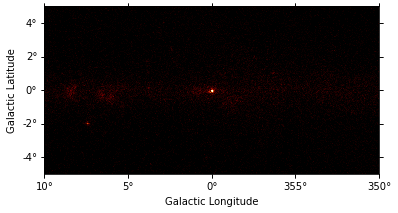

In [56]:
m_3fhl_gc.plot();

We can easily improve the plot by calling `Map.smooth()` first and providing additional arguments to `.plot()`. Most of them are passed further to [plt.imshow()](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.imshow.html):

/Users/adonath/software/mambaforge/envs/gammapy-dev/lib/python3.9/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  return super().imshow(X, *args, origin=origin, **kwargs)


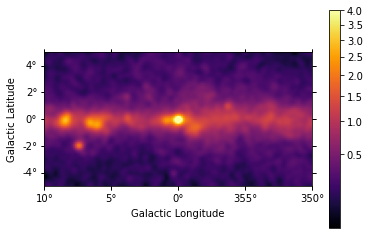

In [57]:
smoothed = m_3fhl_gc.smooth(width=0.2 * u.deg, kernel="gauss")
smoothed.plot(stretch="sqrt", add_cbar=True, vmax=4, cmap="inferno");

We can use the [plt.rc_context()](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.rc_context.html) context manager to further tweak the plot by adapting the figure and font size:

/Users/adonath/software/mambaforge/envs/gammapy-dev/lib/python3.9/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  return super().imshow(X, *args, origin=origin, **kwargs)


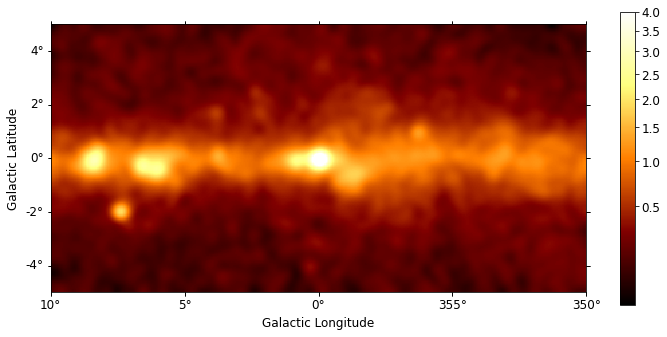

In [58]:
rc_params = {"figure.figsize": (12, 5.4), "font.size": 12}
with plt.rc_context(rc=rc_params):
    smoothed = m_3fhl_gc.smooth(width=0.2 * u.deg, kernel="gauss")
    smoothed.plot(stretch="sqrt", add_cbar=True, vmax=4);

### Cube plotting 

For maps with non-spatial dimensions the `Map` object features an interactive plotting method, that works in jupyter notebooks only (Note: it requires the package `ipywidgets` to be installed). We first read a small example cutout from the Fermi Galactic diffuse model and display the data cube by calling `.plot_interactive()`:

In [59]:
rc_params = {
    "figure.figsize": (12, 5.4),
    "font.size": 12,
    "axes.formatter.limits": (2, -2),
}
m_iem_gc.plot_interactive(add_cbar=True, stretch="sqrt", rc_params=rc_params)

interactive(children=(SelectionSlider(continuous_update=False, description='Select energy_true:', layout=Layou…

Now you can use the interactive slider to select an energy range and the corresponding image is displayed on the screen. You can also use the radio buttons to select your preferred image stretching. We have passed additional keywords using the `rc_params` argument to improve the figure and font size. Those keywords are directly passed to the [plt.rc_context()](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.rc_context.html) context manager.

Additionally all the slices of a 3D `Map` can be displayed using the `.plot_grid()` method. By default the colorbars bounds of the subplots are not the same, we can make them consistent using the `vmin` and `vmax` options:

/Users/adonath/software/mambaforge/envs/gammapy-dev/lib/python3.9/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  return super().imshow(X, *args, origin=origin, **kwargs)


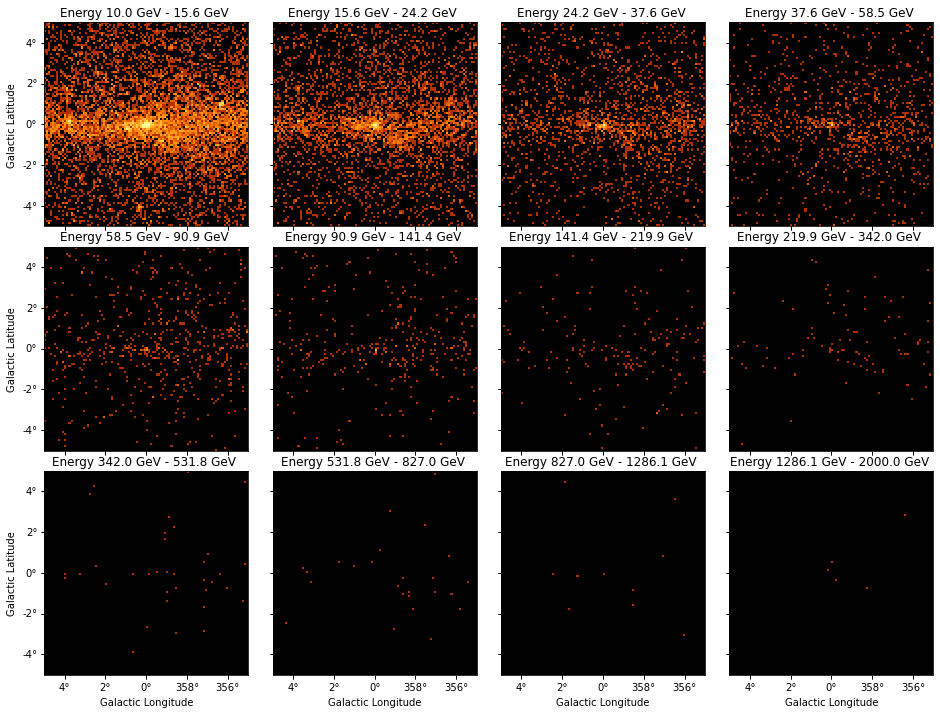

In [60]:
counts_3d.plot_grid(ncols=4, figsize=(16, 12), vmin=0, vmax=100, stretch="log");